In [9]:
import random
import string
import math
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

# Pastikan TensorFlow menggunakan GPU jika tersedia, jika tidak, gunakan CPU.
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    print("No GPU is available. Using CPU.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in test_labels]

# Selanjutnya, Anda dapat melanjutkan dengan pemrosesan data dan model pengenalan teks seperti biasa.


No GPU is available. Using CPU.
Looking for .\borndigital\Challenge1_Training_Task3_Images_GT.zip
Looking for .\borndigital\Challenge1_Test_Task3_Images.zip
Looking for .\borndigital\test\Challenge1_Test_Task3_GT.txt


In [10]:
from keras_ocr.recognition import Recognizer

recognizer = Recognizer()
recognizer.compile()


Looking for C:\Users\Aqil Wahid\.keras-ocr\crnn_kurapan.h5


In [11]:
import imgaug
import sklearn.model_selection
import keras_ocr

batch_size = 8

# Augmenter menggunakan imgaug
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

# Pisahkan dataset menjadi data latih dan validasi
train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)

# Definisikan generator gambar untuk data latih dan validasi
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]

# Dapatkan generator batch untuk data latih dan validasi
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]


482 / 2853 instances have illegal characters.
text: 249


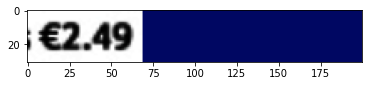

In [12]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)


In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]

# Fit model menggunakan generator data latih dan validasi
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1,
)


C:\Users\Aqil Wahid\AppData\Local\Temp\ipykernel_13804\2809828826.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


356/356 [==============================] - 510s 1s/step - loss: 3.0602 - val_loss: 2.6121


Prediksi: devaloper, Sebenarnya: developer


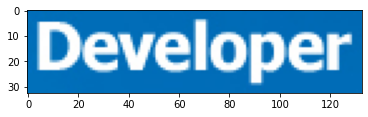

In [14]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Prediksi: {predicted}, Sebenarnya: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))


In [15]:
recognizer.model.load_weights('recognizer_borndigital.h5')
